In [1]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-11-24-01-21-25/model-30.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-11-26-22-56-38/model-27.pt',
    'clvp2.pth': '',
    'diffusion.pth': '~/tortoise_plus_zh/ttts/diffusion/logs/2023-10-27-00-00-28/model-12.pt',
    'vocoder.pth': '~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [2]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:1'
# text = "大家好，今天来点大家想看的东西。"
# text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
# text = '高德官方网站，拥有全面、精准的地点信息，公交驾车路线规划，特色语音导航，商家团购、优惠信息。'
text = '先帝创业未半而中道崩殂，今天下三分，益州疲弊，此诚危急存亡之秋也。然侍卫之臣不懈于内，忠志之士忘身于外者，盖追先帝之殊遇，欲报之于陛下也。诚宜开张圣听，以光先帝遗德，恢弘志士之气，不宜妄自菲薄，引喻失义，以塞忠谏之路也。'
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

xian1 di4 chuang4 ye4 wei4 ban4 er2 zhong1 dao4 beng1 cu2 ， jin1 tian1 xia4 san1 fen1 ， yi4 zhou1 pi2 bi4 ， ci3 cheng2 wei1 ji2 cun2 wang2 zhi1 qiu1 ye3 。 ran2 shi4 wei4 zhi1 chen2 bu4 xie4 yu2 nei4 ， zhong1 zhi4 zhi1 shi4 wang4 shen1 yu2 wai4 zhe3 ， gai4 zhui1 xian1 di4 zhi1 shu1 yu4 ， yu4 bao4 zhi1 yu2 bi4 xia4 ye3 。 cheng2 yi2 kai1 zhang1 sheng4 ting1 ， yi3 guang1 xian1 di4 yi2 de2 ， hui1 hong2 zhi4 shi4 zhi1 qi4 ， bu4 yi2 wang4 zi4 fei3 bo2 ， yin3 yu4 shi1 yi4 ， yi3 sai1 zhong1 jian4 zhi1 lu4 ye3 。
tensor([[ 62,  71,   2, 158,   2, 235,  82,   2, 179,   2, 140,   2,  10,  63,
           2, 189,   2, 134,   2, 133,   2,  10, 115,   2,  11,  73,   2,  43,
           2, 224,   2, 171,  71,   2, 222,   2, 138,   2,  14, 119,   2,  43,
           2, 130,   2,  53, 127,   2,  24,  58,   2,  10,  48,   2,  43,   2,
          11,  59,   2, 147,   2,  31, 231,   2, 208,   2,  11,  29, 142,   2,
          31, 100,   2, 178,   2, 101,  80,   2, 218,   2,  39,   2,  26,  69,
           2,  77,

In [3]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '0.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([1, 100, 433])


In [4]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 1.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
# text_tokens = F.pad(text_tokens,(0,400-text_tokens.shape[1]),value=0)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 433])
torch.Size([1, 271])
torch.Size([1, 271])
tensor([[2520,  558, 1656, 1654,  348, 1794, 1394, 3939, 2303,   59, 4455,  181,
         7155,  810, 1874, 2002, 2599, 6216,  104, 6455, 1967, 6551, 3120, 5041,
         8025, 1790, 2381,   67, 5750,  179, 3575, 2182, 3830, 5809, 6916,  879,
         7657, 5297, 2807, 1297, 6149, 7875, 4942, 5582, 6552, 6288,  396,  411,
          217, 4514, 4887, 6585,  962, 7239, 3679, 1405, 2490, 4883, 5641, 3869,
         5033, 1197, 2575, 1059, 5913,  584, 7677, 6877, 4864, 3780, 7029,  723,
         5284,  530, 7659, 4777, 2495, 6723, 1487, 3847, 3699, 4872, 6772, 4217,
         5395, 1619, 6986, 3994, 3249, 5779,  785, 5533, 5203,   84, 3367, 4222,
         2076, 2363, 1412, 5859, 2603,   89,  791, 2370, 7661,  267, 7121, 3233,
         2036, 4215, 8046,  767, 3251,  741, 7969, 5664,  965, 4232,  271, 7537,
         5536, 2900, 2090, 4511,  726, 5503,  170, 7816, 6984, 4415, 5681, 1725,
         7610, 3878, 1598,   16, 2536,   

In [5]:
vqvae = load_model('vqvae', MODELS['vqvae.pth'], 'vqvae/config.json', device)
mel = vqvae.decode(codes[:,:-1])[0]
codes_gt = vqvae.get_codebook_indices(cond_mel)
print(codes_gt)
mel.shape

tensor([[5476, 5101, 2520, 1291, 2574, 2427,  531, 1412, 6675, 3639,  813, 7765,
         2682,   21, 2863,  584, 6710, 3735, 3783, 1078, 1319, 1807, 5462,  533,
         3922, 5316, 1909,  798, 2380,  730, 2896, 5842, 5047, 6772, 3949, 6348,
         5617,  217, 7045,  772, 7718, 6907, 6907,  271, 8075, 3767, 4561, 1654,
         3780, 5973,  527, 7177,  527, 6520,  751, 4299,  515, 6038, 4814, 4690,
         3800, 6663, 1098, 3679, 6619, 1839, 2156, 3218, 7155,  757, 1107, 1409,
         6004, 2735,  170, 7627,  104, 1630, 2415, 1611, 3558, 2002, 6551,  163,
         2692, 5681, 7992, 7586,   59, 3621, 2267, 2907, 1610, 7117, 6243, 3121,
         1101, 1621, 2374, 4686, 7010, 7820, 7992, 7734, 3932, 2490, 5484, 2279,
         1581]], device='cuda:1')


torch.Size([1, 100, 1876])

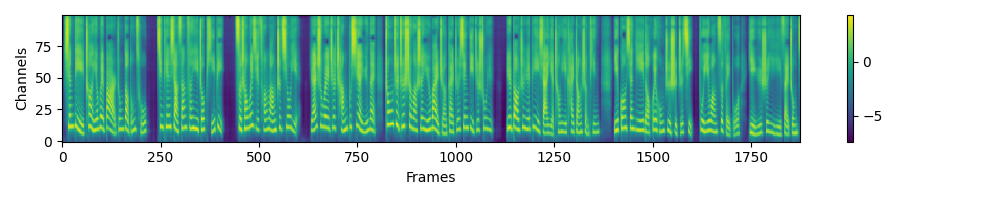

In [6]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [7]:
from ttts.vocoder.vocos import Vocos


vocos = Vocos.from_pretrained('pretrained_models/pytorch_model.bin','vocoder/config.yaml').to(device)
audio = vocos.decode(mel)
print(audio.shape)
torchaudio.save('gen.wav',audio.detach().cpu(), 24000)

torch.Size([1, 480000])


In [25]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False)
latent.shape

torch.Size([1, 123, 1024])

In [ ]:

mel = do_spectrogram_diffusion(diffusion, diffuser, latents, diffusion_conditioning, temperature=diffusion_temperature, 
                                                    verbose=verbose)
                        wav = vocoder.inference(mel)

In [33]:
from ttts.vocoder.vocos import Vocos
from IPython.display import Audio
vocoder = Vocos.from_pretrained("~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","~/tortoise_plus_zh/ttts/vocoder/config.yaml")
audio = vocoder.decode(mel.cpu())
torchaudio.save('gen_0.wav',audio,24000)
Audio('gen_0.wav')